In [1]:
import sympy
from sympy import I, re, im
from sympy.parsing.sympy_parser import (parse_expr, standard_transformations,
                                        implicit_multiplication_application,convert_xor)
from IPython.display import display
sympy.init_printing(use_latex='mathjax')
import numpy as np
np.set_printoptions(suppress=True)
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, generate_preset_pass_manager, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

In [42]:

func_str = input("Enter the smooth function to integrate (e.g., sin(x) * exp(-x)): ")
lower_limit_str = input("Enter the lower limit of integration (e.g., 0): ")
upper_limit_str = input("Enter the upper limit of integration (e.g., pi): ")

# variables
x = sympy.symbols('x',real=True)

try:
    # Parse inputs
    local_dict= {'x':x, 'I':I, 'i':I}
    global_dict= sympy.__dict__
    transformations = standard_transformations + (implicit_multiplication_application,convert_xor)
    
    func_expr = parse_expr(func_str,
                        local_dict=local_dict,
                        global_dict=global_dict,
                        transformations=transformations)

    lower_limit = sympy.sympify(lower_limit_str)
    upper_limit = sympy.sympify(upper_limit_str)

    func= sympy.simplify(func_expr)

    # Display integration expression
    integral_expr = sympy.Integral(func_expr, (x, lower_limit, upper_limit))

    print("Entered definite integral Mathematical expression:")
    display(integral_expr)

except (sympy.SympifyError, SyntaxError) as e:
    print(f"\nError: Could not parse the input. Please check entered expression. Details: {e}")


Entered definite integral Mathematical expression:


π          
⌠          
⎮ sin(x) dx
⌡          
0          

In [39]:
def getTaylorPolynomial(function,d,lower_limit,upper_limit):

    print(f"TAYLOR's APPROXIMATION to {d}th degree : ")
    # point of approximation x0= a+b/2
    x0= (upper_limit+lower_limit)/2

        # 2. Check differentiability (will pass for these smooth pieces)
    try:
        deriv_val = sympy.diff(function, x).evalf(subs={x: x0})
        if "nan" in str(deriv_val) or "oo" in str(deriv_val):
            raise ValueError("Still not differentiable")
    except Exception as e:
        print(f"Error on interval [{lower_limit},{upper_limit}]: {e}")
        return None
    
    taylor_polynomial= sympy.series(function,x,x0,d+1).removeO()

    # Display integration expression
    integration_expr = sympy.Integral(taylor_polynomial, (x, lower_limit, upper_limit))
    display(integration_expr)
    return taylor_polynomial


In [24]:
# Discretize func_expr
def discretize(func,lower_limit, upper_limit,N):
    upper_limit= float(upper_limit)
    lower_limit= float(lower_limit)
    
    f_callable= sympy.lambdify(x, func, 'numpy')

    # N random X points such that there are N random F(x). Sigma F(x) deltaX is integral (RIEMANN SUM)
    x_array = np.random.uniform(lower_limit,upper_limit,N)
    y_array= f_callable(x_array)
   
    return y_array,x_array 

In [25]:
def IntegrateClassical(y,lower_limit, upper_limit,N):
    
    classical_iterations= np.cumsum(y, dtype= float)

    # Average
    for i in range(N):
        classical_iterations[i]=classical_iterations[i]/(i+1)

    # Integral = SIGMA f(x) delta x
    Classical_integral= classical_iterations*(upper_limit-lower_limit)

    return Classical_integral

In [35]:
# Degree of Approximation
d= 12
num_qubits=13
N=2**num_qubits

In [43]:
taylor_function= getTaylorPolynomial(func, d,lower_limit,upper_limit)
if taylor_function!= None:
    y, x_array=discretize(taylor_function,lower_limit,upper_limit,N)
    answer= IntegrateClassical(y,lower_limit, upper_limit,N)

    print("Y Array:")
    print(y)


    classical_answer= float(answer[N-1])
    print("\nClassical Integration Answer:")
    print(classical_answer)
else:
    print("ERROR getting the polynomial")

TAYLOR's APPROXIMATION to 12th degree : 


π                                                                           
⌠                                                                           
⎮ ⎛       12          10          8          6          4          2    ⎞   
⎮ ⎜⎛    π⎞     ⎛    π⎞     ⎛    π⎞    ⎛    π⎞    ⎛    π⎞    ⎛    π⎞     ⎟   
⎮ ⎜⎜x - ─⎟     ⎜x - ─⎟     ⎜x - ─⎟    ⎜x - ─⎟    ⎜x - ─⎟    ⎜x - ─⎟     ⎟   
⎮ ⎜⎝    2⎠     ⎝    2⎠     ⎝    2⎠    ⎝    2⎠    ⎝    2⎠    ⎝    2⎠     ⎟   
⎮ ⎜───────── - ───────── + ──────── - ──────── + ──────── - ──────── + 1⎟ dx
⎮ ⎝479001600    3628800     40320       720         24         2        ⎠   
⌡                                                                           
0                                                                           

Y Array:
[0.90445596 0.57748978 0.74129708 ... 0.78931515 0.77096485 0.95845751]

Classical Integration Answer:
1.990641816277964


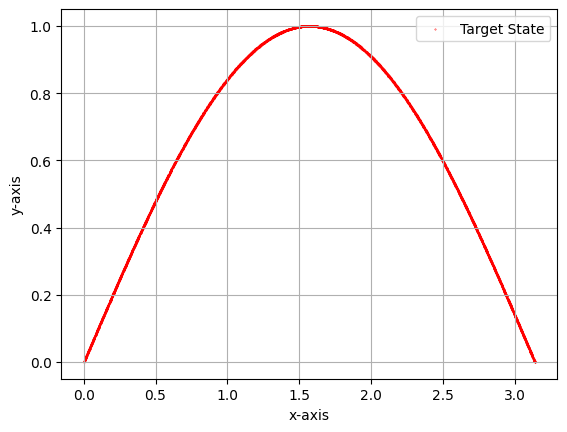

In [44]:
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.scatter(x_array,y,
             color='red', label='Target State',s=0.1)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def walsh_loader(qc,Qbit,ancilla,y,N):
    # Min-Max scale y
    y= y
    wh_transform=np.array(sympy.fwht(y), dtype=float)/np.sqrt(N)

    
    print("THIS IS Y L2 NORMALIZED")
    print(y)

    print("THIS IS AFTER APPLYING FWHT")
    print(wh_transform)

    return qc

In [65]:
def variable_Change(taylor_function,lower_limit,upper_limit):
    
    # Original integral: integral from a to b of f(x) dx
    # X= 0 to 1, x = a to b      as f is uniform, X= (x-a)/b-a,   x= X(b-a)+ a
    # dX=   dx/b-a, dx= dX* (b-a)
    # New integral: integral from 0 to 1 of f(a + (b-a)X) * (b-a) dX
    scaling_factor = upper_limit-lower_limit
    scaled_taylorPoly = taylor_function.subs(x, lower_limit + scaling_factor * x) * scaling_factor

    a=0
    b=1

    scaled_taylorPoly= sympy.expand(scaled_taylorPoly)

    coefficients= np.array(scaled_taylorPoly.as_coefficients_dict(x))
    print(f"These are all the {type(coefficients)} coefficients")
    print(coefficients)


    # 4. Calculate the upper bound M using the triangle inequality for scaling
    # M = sum(|c_k| * max(|u^k|)) for u in [0, 1]. Since u is in [0, 1], max(|u^k|) is 1.
    M = 0

    


    integral_expr = sympy.Integral(taylor_function, (x,a,b))
    display(integral_expr)

    
    return scaled_taylorPoly, a, b

In [66]:

scaled_taylorPoly, a,b= variable_Change(taylor_function,lower_limit, upper_limit)


Qbit= QuantumRegister(num_qubits,name='logical')
Cbit= ClassicalRegister(num_qubits,name='result')
ancilla= QuantumRegister(3,name='anc')

qc= QuantumCircuit(Qbit,ancilla,Cbit)
#Equal Superposition
qc.h(Qbit)
qc.barrier()

#qc= walsh_loader(qc,Qbit,ancilla,,N)



These are all the <class 'numpy.ndarray'> coefficients
defaultdict(<class 'int'>, {x: -pi**5/48 - pi**9/645120 - pi**13/81749606400 + pi**11/185794560 + pi**7/3840 + pi**3/2, x**2: -pi**3/2 - pi**7/768 - pi**11/20643840 + pi**13/7431782400 + pi**9/92160 + pi**5/16, x**3: -pi**5/12 - pi**9/23040 - pi**13/1114767360 + pi**11/3870720 + pi**7/288, x**4: -pi**7/192 - pi**11/1105920 + pi**13/247726080 + pi**9/9216 + pi**5/24, x**6: -pi**7/720 - pi**11/276480 + pi**13/33177600 + pi**9/5760, x**5: -pi**9/5760 - pi**13/77414400 + pi**11/460800 + pi**7/240, x**7: -pi**9/10080 - pi**13/19353600 + pi**11/241920, x**8: -pi**11/322560 + pi**13/15482880 + pi**9/40320, x**10: -pi**11/3628800 + pi**13/29030400, x**9: -pi**13/17418240 + pi**11/725760, x**11: -pi**13/79833600, x**12: pi**13/479001600, 1: -pi**3/8 - pi**7/46080 - pi**11/3715891200 + pi**13/1961990553600 + pi**9/10321920 + pi**5/384 + pi})


1                                                                           
⌠                                                                           
⎮ ⎛       12          10          8          6          4          2    ⎞   
⎮ ⎜⎛    π⎞     ⎛    π⎞     ⎛    π⎞    ⎛    π⎞    ⎛    π⎞    ⎛    π⎞     ⎟   
⎮ ⎜⎜x - ─⎟     ⎜x - ─⎟     ⎜x - ─⎟    ⎜x - ─⎟    ⎜x - ─⎟    ⎜x - ─⎟     ⎟   
⎮ ⎜⎝    2⎠     ⎝    2⎠     ⎝    2⎠    ⎝    2⎠    ⎝    2⎠    ⎝    2⎠     ⎟   
⎮ ⎜───────── - ───────── + ──────── - ──────── + ──────── - ──────── + 1⎟ dx
⎮ ⎝479001600    3628800     40320       720         24         2        ⎠   
⌡                                                                           
0                                                                           

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=16, num_clbits=0, params=[]), qubits=(<Qubit register=(13, "logical"), index=0>, <Qubit register=(13, "logical"), index=1>, <Qubit register=(13, "logical"), index=2>, <Qubit register=(13, "logical"), index=3>, <Qubit register=(13, "logical"), index=4>, <Qubit register=(13, "logical"), index=5>, <Qubit register=(13, "logical"), index=6>, <Qubit register=(13, "logical"), index=7>, <Qubit register=(13, "logical"), index=8>, <Qubit register=(13, "logical"), index=9>, <Qubit register=(13, "logical"), index=10>, <Qubit register=(13, "logical"), index=11>, <Qubit register=(13, "logical"), index=12>, <Qubit register=(3, "anc"), index=0>, <Qubit register=(3, "anc"), index=1>, <Qubit register=(3, "anc"), index=2>), clbits=())

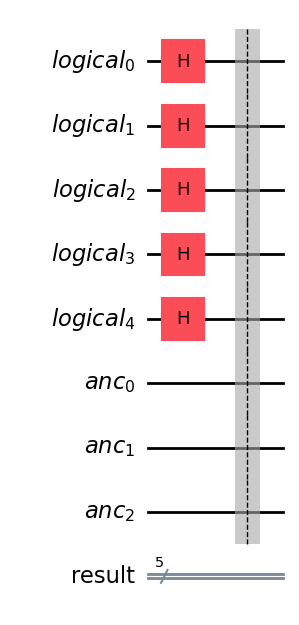

In [86]:
qc.draw('mpl')

In [ ]:
service = QiskitRuntimeService(name="qiskit_adi")
# Get a backend
backend = AerSimulator()
#backend = service.least_busy(operational=True, simulator=False)
#backend= service.backend(name='ibm_torino')
print(f"We are using the {backend.name} quantum computer")
shots= 1024
sampler = Sampler(mode=backend)